# Nortek AD2CP Processing Code

jgradone@marine.rutgers.edu     01/11/2022    Initial

**This Jupyter Notebook is intended to:**<br>
1) Read in AD2CP data processed to NetCDFs using the Nortek MIDAS software as an xarray DataSet and combine all into one massive DataSet <br>
2) QAQC data <br>
3) Bin map data <br>
4) Coordinate transformation from beam to XYZ to ENU <br>
5) Least squares linear inversion to extra true ocean velocity from ADCP velocities (Note: to constrain solution with glider depth averaged velocity, an additional step is needed that is excluded from this notebook. Mainly, this is because it requires matching of timestamps between different datasets in a big loop.) <br>

*Details/comments on what the functions are actually doing in the source code*

In [25]:
# Imports  
import scipy.interpolate as interp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import netCDF4 as nc
import math
import datetime
import xarray as xr
import matplotlib.dates as mdates
import cmocean.cm as cmo
import sys

## To import functions from Slocum-AD2CP GitHub repository, make this path the path to where the repo exists locally
sys.path.insert(0,'/home/jg1200/GitHub/Slocum-AD2CP/src/data/')
from make_dataset import ad2cp_nc_to_xarray, correct_sound_speed, cell_vert, binmap_adcp, beam2enu, inversion, qaqc_pre_coord_transform


## Set some plotting formats
plt.style.use('seaborn-poster')
myFmtshort = mdates.DateFormatter('%m/%d\n%H:%M')
myFmtlong = mdates.DateFormatter('%m/%d/%y \n%H:%M')
myFmt = mdates.DateFormatter('%m/%d/%y')

## Set path for where all the data lives

In [2]:
path = '/home/jg1200/Data/GliderData/RU29/2021_02_17_ru_29_614_post_UVI/'
files = np.sort(glob.glob(path+'*.nc'))

## Load Data

In [3]:
###############################################
# Loop to resave netcdfs in a readable format #
###############################################
# for x in np.arange(0,len(files)):
#     df = ad2cp_nc_to_xarray(files[x])
#     fname = "/home/jg1200/Data/GliderData/RU29/RU29_2020_AD2CP_NC/RU29_2020_AD2CP_{}.nc".format(x)
#     df.to_netcdf(fname)


###############################################
#          Smash all NetCDFs together         #
###############################################
# nc_path = '/home/jg1200/Data/GliderData/RU29/RU29_2020_AD2CP_NC/'
# ncfiles = glob.glob(nc_path+'*.nc')
# tot_ad2cp = xr.open_mfdataset(ncfiles, concat_dim="time", combine="nested",
#                   data_vars='minimal', coords='minimal', compat='override')
# tot_ad2cp = tot_ad2cp.sortby('time')


###############################################
#             Save master dataset             #
###############################################
# fname = "/home/jg1200/Data/GliderData/RU29/RU29_2020_AD2CP_NC/Combined/RU29_2020_AD2CP_Combined.nc"
# tot_ad2cp.to_netcdf(fname)


###############################################
#      Load master dataset if run before      #
###############################################
# fname = "/home/jg1200/Data/GliderData/RU29/RU29_2020_AD2CP_NC/Combined/RU29_2020_AD2CP_Combined.nc"
# df = xr.open_dataset(fname)
# df


###############################################
#         For TESTING: Load first file        #
###############################################
df1 = ad2cp_nc_to_xarray(files[0])
df1


<xarray.Dataset>
Dimensions:             (time: 150080, beams1: 4, beams2: 4, ahrs_rot_mat_dim: 9, bins: 40)
Coordinates:
  * bins                (bins) float32 0.7 1.2 1.7 2.2 ... 18.7 19.2 19.7 20.2
  * time                (time) datetime64[ns] 2020-09-08T17:52:48.032099072 ....
  * beams1              (beams1) int64 1 2 3 4
  * beams2              (beams2) int64 1 2 3 4
  * ahrs_rot_mat_dim    (ahrs_rot_mat_dim) int64 0 1 2 3 4 5 6 7 8
Data variables: (12/34)
    heading             (time) float32 94.69 95.48 96.22 ... 160.1 160.1 160.1
    depth               (time) float64 10.15 10.16 10.18 ... 187.7 187.6 187.6
    pitch               (time) float32 -2.02 -2.2 -2.27 ... 26.24 26.21 26.19
    roll                (time) float32 -11.57 -10.91 -11.44 ... -1.23 -1.23
    speedofsound        (time) float32 1.545e+03 1.545e+03 ... 1.528e+03
    error               (time) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    ...                  ...
    beam3cor            (bins, time) float32 92.0 100.0 100.0 ... 9.0 8.0 2.0
    beam4cor            (bins, time) float32 89.0 88.0 84.0 79.0 ... 4.0 5.0 7.0
    beam1amp            (bins, time) float32 84.0 83.5 84.0 ... 32.5 31.5 32.5
    beam2amp            (bins, time) float32 84.5 84.5 84.5 ... 33.0 32.5 33.0
    beam3amp            (bins, time) float32 84.5 84.5 84.5 ... 32.5 32.5 32.5
    beam4amp            (bins, time) float32 84.5 84.5 84.0 ... 32.5 32.0 32.5

## Take a quick peak at some data

/tmp/ipykernel_59359/3818138162.py:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x[:,12000:14000],-by[:,12000:14000],df1.beam1amp[:,12000:14000])


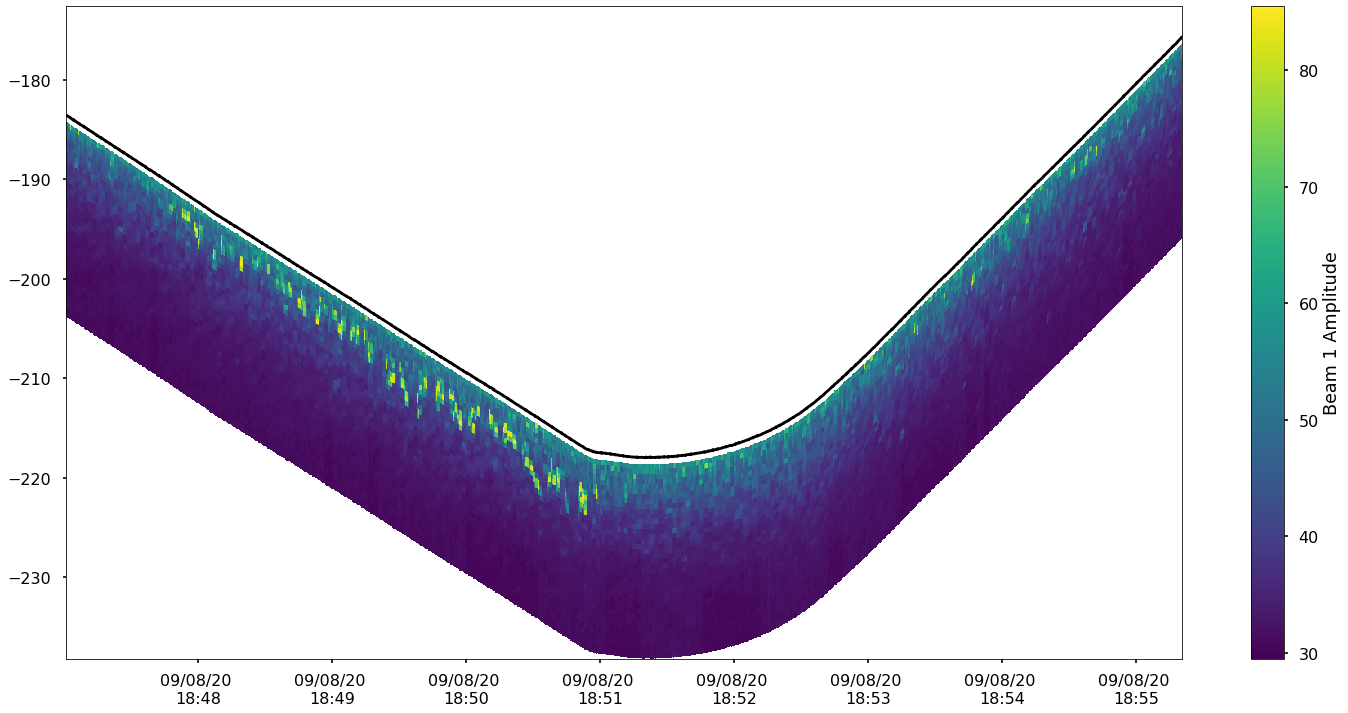

In [4]:
[x,y]=np.meshgrid(df1.time,df1.bins)
[bdepth,bbins]=np.meshgrid(df1.depth,df1.bins)

by=bdepth+bbins

fig = plt.figure(figsize=(25,12))

plt.pcolormesh(x[:,12000:14000],-by[:,12000:14000],df1.beam1amp[:,12000:14000])
plt.plot(df1.time[12000:14000],-df1.depth[12000:14000],'k')
plt.colorbar(label='Beam 1 Amplitude')
plt.gca().xaxis.set_major_formatter(myFmtlong)

## Subset data for testing

In [5]:
df = df1.sel(time=slice(df1.time[87300],df1.time[119000]))
df

<xarray.Dataset>
Dimensions:             (time: 31701, beams1: 4, beams2: 4, ahrs_rot_mat_dim: 9, bins: 40)
Coordinates:
  * bins                (bins) float32 0.7 1.2 1.7 2.2 ... 18.7 19.2 19.7 20.2
  * time                (time) datetime64[ns] 2020-09-09T00:56:34.282000128 ....
  * beams1              (beams1) int64 1 2 3 4
  * beams2              (beams2) int64 1 2 3 4
  * ahrs_rot_mat_dim    (ahrs_rot_mat_dim) int64 0 1 2 3 4 5 6 7 8
Data variables: (12/34)
    heading             (time) float32 96.73 96.77 96.87 ... 125.1 125.1 125.1
    depth               (time) float64 10.93 10.91 10.91 ... 15.46 15.46 15.42
    pitch               (time) float32 0.05 -0.32 -0.82 ... 27.2 27.13 27.05
    roll                (time) float32 -0.84 -0.55 -0.33 ... -0.79 -0.81 -0.83
    speedofsound        (time) float32 1.545e+03 1.545e+03 ... 1.544e+03
    error               (time) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    ...                  ...
    beam3cor            (bins, time) float32 96.0 98.0 83.0 ... 16.0 8.0 23.0
    beam4cor            (bins, time) float32 85.0 87.0 77.0 ... 24.0 16.0 41.0
    beam1amp            (bins, time) float32 80.5 81.0 79.5 ... 32.5 32.0 32.5
    beam2amp            (bins, time) float32 66.5 66.5 65.5 ... 34.0 34.0 33.5
    beam3amp            (bins, time) float32 69.0 68.5 68.0 ... 32.0 31.5 31.0
    beam4amp            (bins, time) float32 73.5 76.5 77.5 ... 32.5 32.5 33.0

/tmp/ipykernel_59359/2893769502.py:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x,-by,df.beam1amp)


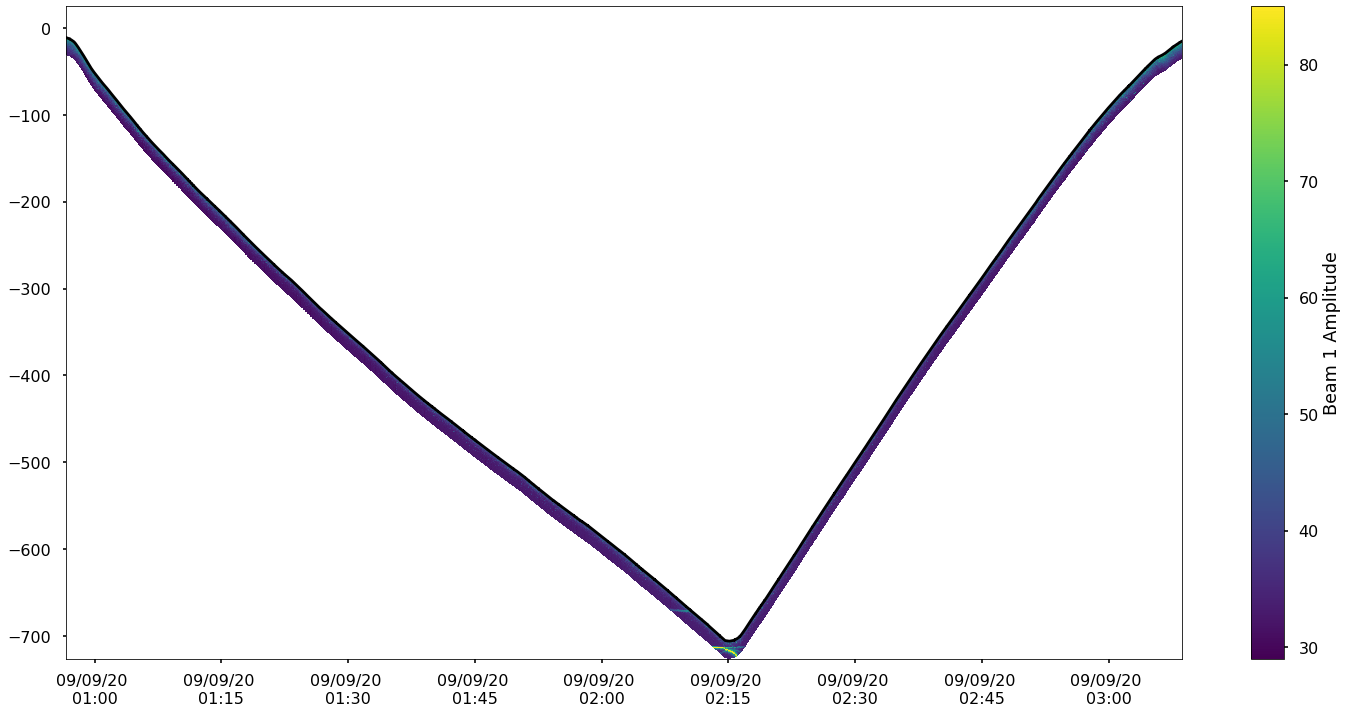

In [6]:
[x,y]=np.meshgrid(df.time,df.bins)
[bdepth,bbins]=np.meshgrid(df.depth,df.bins)

by=bdepth+bbins

fig = plt.figure(figsize=(25,12))

plt.pcolormesh(x,-by,df.beam1amp)
plt.plot(df.time,-df.depth,'k')
plt.colorbar(label='Beam 1 Amplitude')
plt.gca().xaxis.set_major_formatter(myFmtlong)

# Processing Step 1: Pitch Dependent Magnetic Correction for Heading
The pitch of the glider changes by moving the pitch-battery pack. The pitch-battery produces a magnetic field so when it moves, the field moves and this effects our compass data. Having all of the data from a mission loaded in for this correction ensures the best fit possible.

### Still in development

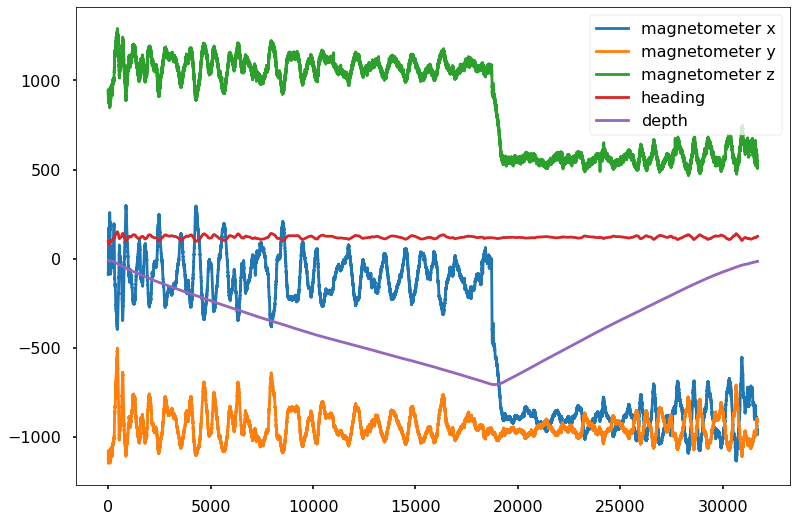

In [7]:
start = 0
end = 50000

#start = 255000 # Works well for full AD2CP dataset
#end = 290000

plt.plot(df.magnetometerx[start:end],label='magnetometer x')
plt.plot(df.magnetometery[start:end],label='magnetometer y')
plt.plot(df.magnetometerz[start:end],label='magnetometer z')
plt.plot(df.heading[start:end],label='heading')
plt.plot(-df.depth[start:end],label='depth')
plt.legend()

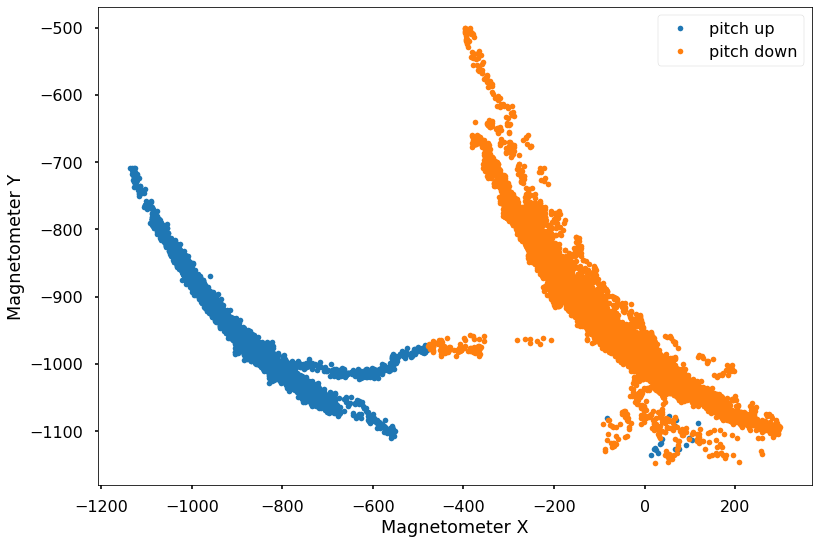

In [8]:
pitch_up_ind = np.where(df.pitch.values>0)
pitch_down_ind = np.where(df.pitch.values<0)

plt.plot(df.magnetometerx[pitch_up_ind],df.magnetometery[pitch_up_ind],'.',label='pitch up')
plt.plot(df.magnetometerx[pitch_down_ind],df.magnetometery[pitch_down_ind],'.',label='pitch down')
plt.xlabel('Magnetometer X')
plt.ylabel('Magnetometer Y')
plt.legend()

In [9]:
def ellipsoid_fit(x,y,z):
    # Adapted from http://www.mathworks.com/matlabcentral/fileexchange/24693-ellipsoid-fit
    
    # Input:
    # x : magnetometer x from AD2CP AHRS
    # y : magnetometer y from AD2CP AHRS
    # z : magnetometer z from AD2CP AHRS
    
    # Output:
    #     center    -  ellispoid or other conic center coordinates [xc; yc; zc]
    #     radii     -  ellipsoid or other conic radii [a; b; c]
    #     evecs     -  the radii directions as columns of the 3x3 matrix

    D = np.array([x * x + y * y - 2 * z * z,
                 x * x + z * z - 2 * y * y,
                 2 * x * y,
                 2 * x * z,
                 2 * y * z,
                 2 * x,
                 2 * y,
                 2 * z,
                 1 - 0 * x])
    d2 = np.array(x * x + y * y + z * z).T # rhs for LLSQ
    u = np.linalg.solve(D.dot(D.T), D.dot(d2))
    a = np.array([u[0] + 1 * u[1] - 1])
    b = np.array([u[0] - 2 * u[1] - 1])
    c = np.array([u[1] - 2 * u[0] - 1])
    v = np.concatenate([a, b, c, u[2:]], axis=0).flatten()
    A = np.array([[v[0], v[3], v[4], v[6]],
                  [v[3], v[1], v[5], v[7]],
                  [v[4], v[5], v[2], v[8]],
                  [v[6], v[7], v[8], v[9]]])

    center = np.linalg.solve(- A[:3, :3], v[6:9])

    translation_matrix = np.eye(4)
    translation_matrix[3, :3] = center.T

    R = translation_matrix.dot(A).dot(translation_matrix.T)

    evals, evecs = np.linalg.eig(R[:3, :3] / -R[3, 3])
    evecs = evecs.T

    radii = np.sqrt(1. / np.abs(evals))
    radii *= np.sign(evals)

    return center, evecs, radii,


# def CalcTiltMatrix(pitch, roll):
#     sinpp = np.sin(np.rad2deg(pitch))
#     cospp = np.cos(np.rad2deg(pitch))
#     sinrr = np.sin(np.rad2deg(roll))
#     cosrr = np.cos(np.rad2deg(roll))

# M = [cospp -sinpp*sinrr  -cosrr*sinpp;...
#        0       cosrr         -sinrr;  ...
#      sinpp  sinrr*cospp  cospp*cosrr ]; 


In [10]:
up_center, up_evecs, up_radii = ellipsoid_fit(df.magnetometerx[pitch_up_ind],df.magnetometery[pitch_up_ind],df.magnetometerz[pitch_up_ind])
down_center, down_evecs, down_radii = ellipsoid_fit(df.magnetometerx[pitch_down_ind],df.magnetometery[pitch_down_ind],df.magnetometerz[pitch_down_ind])



In [11]:
def mag_correct(magnetometerx,magnetometery,magnetometerz,pitch):
    
    ## Finds where pitch is positive/negative to apply difference ellpsoid corrections
    pitch_up_ind = np.where(pitch>0)
    pitch_down_ind = np.where(pitch<0)

    ## Fits the given cartesian coordinates to an ellipsoid
    up_center, up_evecs, up_radii = ellipsoid_fit(magnetometerx[pitch_up_ind],magnetometery[pitch_up_ind],magnetometerz[pitch_up_ind])
    down_center, down_evecs, down_radii = ellipsoid_fit(magnetometerx[pitch_down_ind],magnetometery[pitch_down_ind],magnetometerz[pitch_down_ind])

    ## Creates xyz variables that are offset by the center of the magnetic field recorded in the data
    offset_x_up = magnetometerx[pitch_up_ind]-up_center[0]
    offset_y_up = magnetometery[pitch_up_ind]-up_center[1]
    offset_z_up = magnetometerz[pitch_up_ind]-up_center[2]
    
    offset_x_down = magnetometerx[pitch_down_ind]-down_center[0]
    offset_y_down = magnetometery[pitch_down_ind]-down_center[1]
    offset_z_down = magnetometerz[pitch_down_ind]-down_center[2]
    
    ## Finds the center of the new magnetic data that should be closer to (0,0,z) than original data
    new_center_up, new_evecs_up, new_radii_up = ellipsoid_fit(offset_x_up,offset_y_up,offset_z_up)
    new_center_down, new_evecs_down, new_radii_down = ellipsoid_fit(offset_x_down,offset_y_down,offset_z_down)
    
    


    
mag_correct(df.magnetometerx,df.magnetometery,df.magnetometerz,df.pitch.values)

# Processing Step 2: QAQC Pre-Coordinate Transformation

## QAQC Step 1: Correct for local speed of sound (Fischer and Visbeck, 1993)
Where C is the real sound speed at the transducer, and CA is the speed of sound used by the ADCP. CA used by the Nortek AD2CP is 1500 m/s.

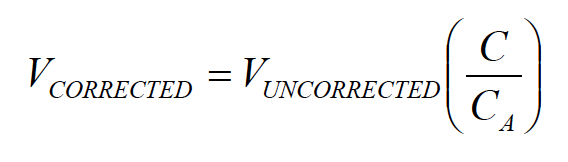

In [12]:
df.beam1vel.values = correct_sound_speed(df.beam1vel, df.speedofsound, 1500)
df.beam2vel.values = correct_sound_speed(df.beam2vel, df.speedofsound, 1500)
df.beam3vel.values = correct_sound_speed(df.beam3vel, df.speedofsound, 1500)
df.beam4vel.values = correct_sound_speed(df.beam4vel, df.speedofsound, 1500)

## QAQC Step 2 & 3: Filter for Extreme Amplitude Returns and Below 0.5 Correlation (Todd et al. 2017)

In [13]:

df.beam1vel.values, df.beam2vel.values, df.beam3vel.values, df.beam4vel.values = qaqc_pre_coord_transform(df.beam1vel,df.beam2vel,df.beam3vel,df.beam4vel,df.beam1amp,df.beam2amp,df.beam3amp,df.beam4amp,df.beam1cor,df.beam2cor,df.beam3cor,df.beam4cor,df.pitch)


In [18]:
df.blanking[0]

<xarray.DataArray 'blanking' ()>
array(0.20000001)
Coordinates:
    time     datetime64[ns] 2020-09-09T00:56:34.282000128

# Processing Step 3: Bin Mapping
Interpolate to set depth grid, this will also effectively filter out extreme pitch and roll

## Loop to actually bin map beam velocities

The function binmap_adcp() was written to work for a single ping so it needs to be run in a loop through every ping

In [19]:
for x in np.arange(0,df.beam1vel.shape[1]):
    # Note the variable roll cannot be called with df.roll as roll() is a function that can be applied to a dataframe
    #     df.beam1vel.values[:,x] = binmap_adcp(df.beam1vel[:,x],df.pitch[x],df['roll'][x],df.bins)
    #     df.beam2vel.values[:,x] = binmap_adcp(df.beam2vel[:,x],df.pitch[x],df['roll'][x],df.bins)
    #     df.beam3vel.values[:,x] = binmap_adcp(df.beam3vel[:,x],df.pitch[x],df['roll'][x],df.bins)
    #     df.beam4vel.values[:,x] = binmap_adcp(df.beam4vel[:,x],df.pitch[x],df['roll'][x],df.bins)
    df.beam1vel.values[:,x] = binmap_adcp(df.beam1vel[:,x],df.pitch[x],df['roll'][x],df.bins, df.blanking[0], beam_number = 1)
    df.beam2vel.values[:,x] = binmap_adcp(df.beam2vel[:,x],df.pitch[x],df['roll'][x],df.bins, df.blanking[0], beam_number = 2)
    df.beam3vel.values[:,x] = binmap_adcp(df.beam3vel[:,x],df.pitch[x],df['roll'][x],df.bins, df.blanking[0], beam_number = 3)
    df.beam4vel.values[:,x] = binmap_adcp(df.beam4vel[:,x],df.pitch[x],df['roll'][x],df.bins, df.blanking[0], beam_number = 4)
    

### Take a peak at the bin mapped data

/tmp/ipykernel_59359/2047141222.py:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x[:,12000:14000],-by[:,12000:14000],df.beam1vel[:,12000:14000])


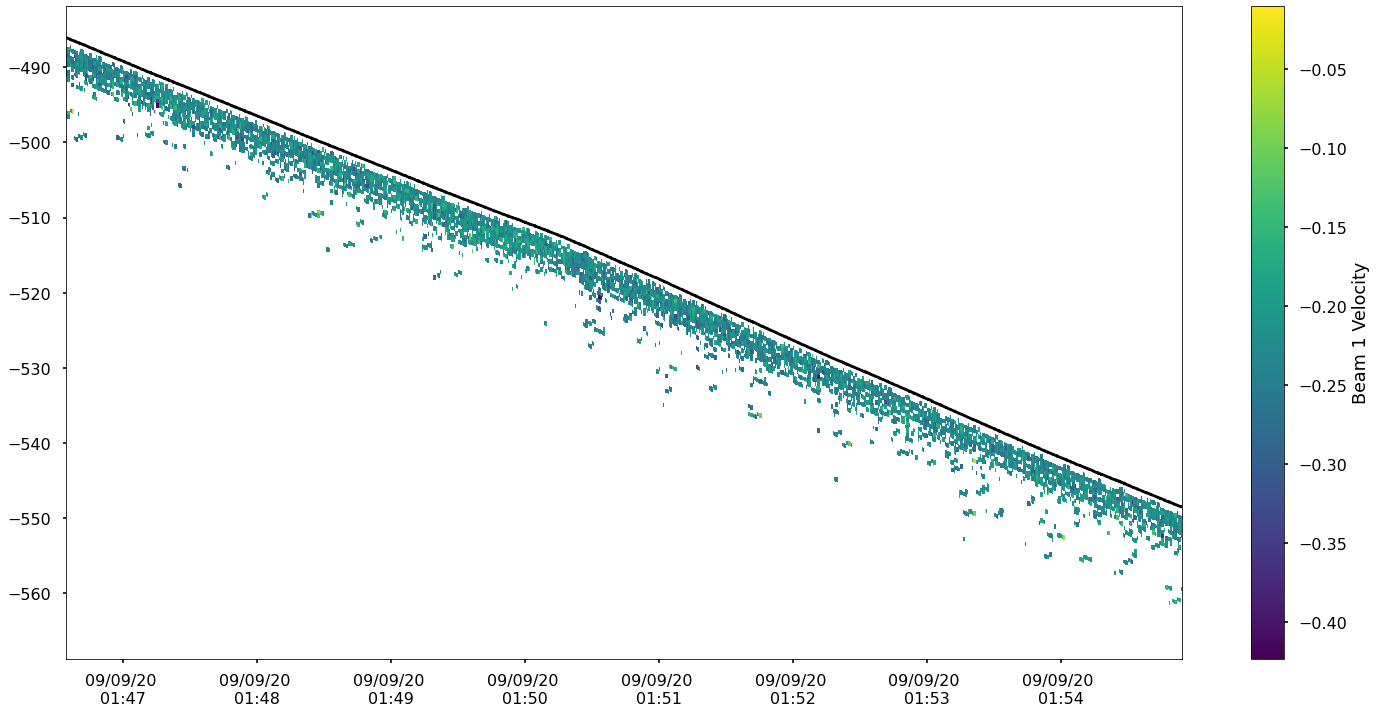

In [20]:
[x,y]=np.meshgrid(df.time,df.bins)
[bdepth,bbins]=np.meshgrid(df.depth,df.bins)

by=bdepth+bbins

fig = plt.figure(figsize=(25,12))

plt.pcolormesh(x[:,12000:14000],-by[:,12000:14000],df.beam1vel[:,12000:14000])
plt.plot(df.time[12000:14000],-df.depth[12000:14000],'k')
plt.colorbar(label='Beam 1 Velocity')
plt.gca().xaxis.set_major_formatter(myFmtlong)

# Processing Step 4: Convert from Beam to XYZ to ENU coordinates

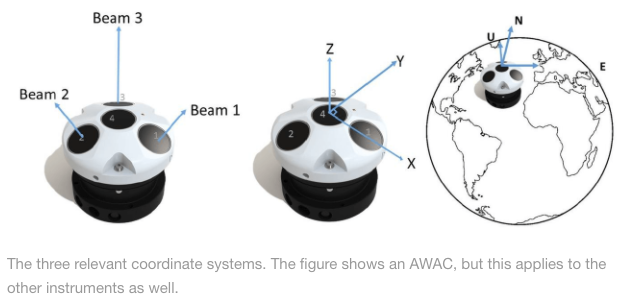

## Loop to actually convert beam to ENU velocity

The function beam2enu() was written to work for a single ping so it needs to be run in a loop through every ping

In [21]:
# Initialize final variables with NaNs first
east             = np.empty([df.beam1vel.shape[0],df.beam1vel.shape[1]])
north            = np.empty([df.beam1vel.shape[0],df.beam1vel.shape[1]])
up               = np.empty([df.beam1vel.shape[0],df.beam1vel.shape[1]])
east[:]          = np.NaN
north[:]         = np.NaN
up[:]            = np.NaN

for k in np.arange(0,df.beam1vel.shape[1]):
        enu = beam2enu(df.beam1vel[:,k],df.beam2vel[:,k],df.beam3vel[:,k],df.beam4vel[:,k],df.beam2xyz.values,df.ahrs_rot_mat.values[k,:],df.pitch[k])

        east[:,k]          = enu[0,:]
        north[:,k]         = enu[1,:]
        up[:,k]            = enu[2,:]

### Take a peak at ENU data

/tmp/ipykernel_59359/1978493790.py:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x[:,12000:14000],-by[:,12000:14000],east[:,12000:14000])


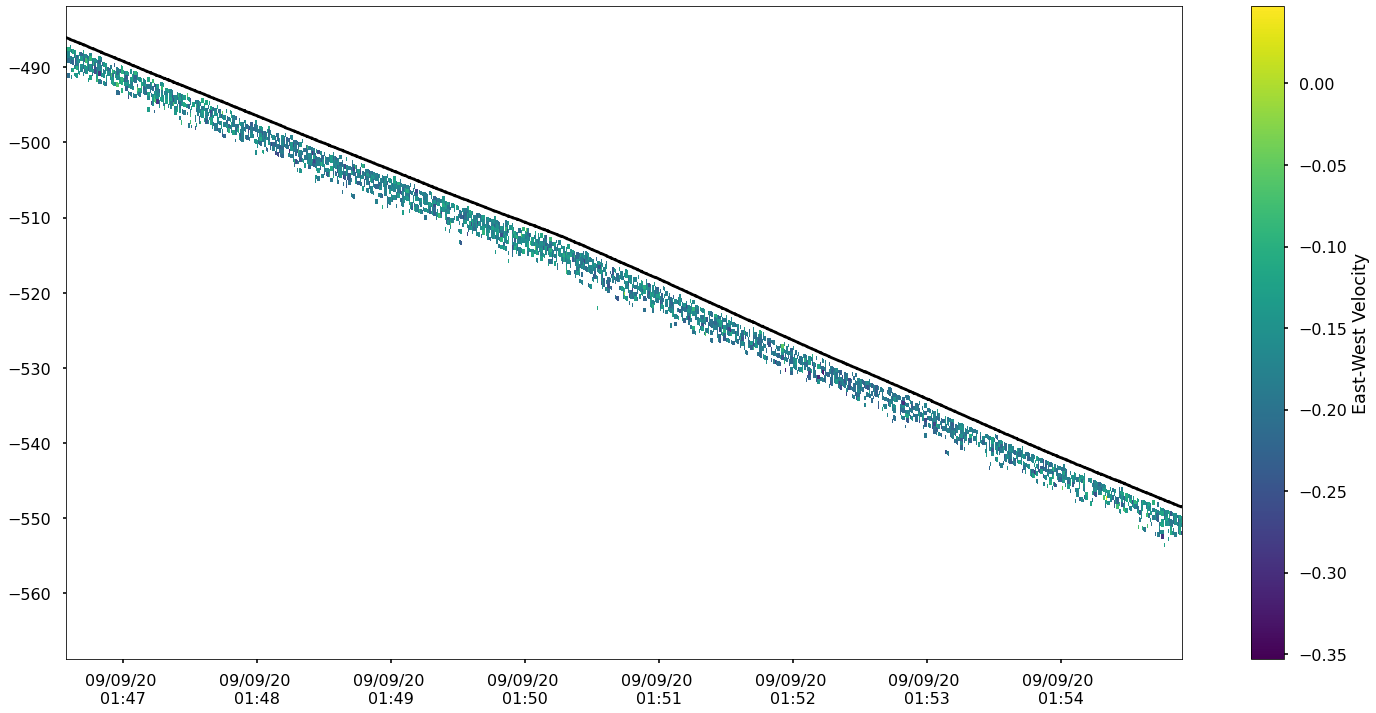

In [22]:
[x,y]=np.meshgrid(df.time,df.bins)
[bdepth,bbins]=np.meshgrid(df.depth,df.bins)

by=bdepth+bbins

fig = plt.figure(figsize=(25,12))

plt.pcolormesh(x[:,12000:14000],-by[:,12000:14000],east[:,12000:14000])
plt.plot(df.time[12000:14000],-df.depth[12000:14000],'k')
plt.colorbar(label='East-West Velocity')
plt.gca().xaxis.set_major_formatter(myFmtlong)

# Processing Step 5: QAQC Post-Coordinate Transformation
## Exclude cells that report velocities relative to the glider exceeding 0.5 m/s

In [23]:
east[east>0.5]   = np.NaN
north[north>0.5] = np.NaN
up[up>0.5]       = np.NaN

# Processing Step 6: Run the inversion!

In [26]:
inversion(U=east.transpose(),V=north.transpose(),H=1000,dz=10,u_daverage=0,v_daverage=0,bins = df.bins, depth = df.depth)


NameError: name 'math' is not defined

In [ ]:
plt.plot(np.real(O_ls),bin_new,label='u - velocity')
plt.plot(np.imag(O_ls),bin_new,label='v - velocity')
plt.ylim(1000,0)
plt.legend()